In [1]:
import xml.dom.minidom as minidom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
def get_node_attr_from_cytoscape(xgmml_filename):
    doc = minidom.parse(xgmml_filename)

    nodes = {}
    for node in doc.getElementsByTagName("node"):
        for att in node.getElementsByTagName("att"):
            if att.getAttribute("name") == "shared name":
                shared_name = att.getAttribute("value")
                graphic = node.getElementsByTagName("graphics")
                if graphic:
                    graphic = graphic[0]
                else:
                    continue
                att = {
                    "name": node.getAttribute("label"),
                    "id": node.getAttribute("id"),
                    "shared_name": shared_name,
                    "x": float(graphic.getAttribute("x")),
                    "y": -float(graphic.getAttribute("y")), # in cytoscape y are negative at the top and positive at the bottom, it's the opposite in matplotlib so we multiply by -1
                    "w": float(graphic.getAttribute("w")),
                    "h": float(graphic.getAttribute("h"))}
                nodes[node.getAttribute("id")] = att
    
    # transform coord to remove negative values
    min_x = min(v["x"] for v in nodes.values())
    min_y = min(v["y"] for v in nodes.values())
    
    for node in nodes:
        nodes[node]["x"] = nodes[node]["x"] + abs(min_x)
        nodes[node]["y"] = nodes[node]["y"] + abs(min_y)
    
    edges = {}
    for edge in doc.getElementsByTagName("edge"):
        source = edge.getAttribute("source")
        target = edge.getAttribute("target")
        
        if not all(e in nodes for e in [source, target]):
            continue
        att = {"source": source, "target": target}
        edges[edge.getAttribute("id")] = att
        
    return nodes, edges

In [3]:
up_down_df = pd.read_csv("/users/mickaelm/mnt/mickaelm/MLf5onto/Results/25_pyRRF_500_new_onto/SPI1.new.tsv", sep="\t", index_col=0)

In [4]:
nodes, edges = get_node_attr_from_cytoscape("edges_name.tsv.xgmml")

columns = ["up", "down", "other"]

for node in nodes:
    if nodes[node]["name"] == "sac":
        nodes[node]["color"] = "orange"
        nodes[node]["type"] = "short_node"
    elif nodes[node]["name"] == "mc":
        nodes[node]["color"] = "green"
        nodes[node]["type"] = "short_node"
    else:
        nodes[node]["color"] = "black"
        nodes[node]["type"] = "chart_node"
        node_name = nodes[node]["shared_name"]
        
        if node_name in up_down_df.index:
            values = up_down_df.loc[node_name, columns].tolist()
        else:
            values = (0., 0., 1.)
        
        for tag, val in zip(columns, values):
            nodes[node][tag] = val

In [5]:
PAD = 6
def custom_node(node, t, ax, fig):
    renderer = fig.canvas.get_renderer()
    
    # get display coord of the text (bbox not included)
    bbox_text = t.get_window_extent(renderer=renderer)
    textbox_w_display = bbox_text.width + PAD*2
    textbox_h_display = bbox_text.height + PAD*2
    
    # display coord of text + bbox
    graph_w_display, graph_h_display = (textbox_h_display, textbox_h_display)
    graph_w_fig, graph_h_fig = fig.transFigure.inverted().transform((graph_w_display, graph_h_display))
    graph_x_display, graph_y_display = (bbox_text.p0[0]-PAD-graph_w_display, bbox_text.p0[1]-PAD)
    graph_x1_display, graph_y1_display = (bbox_text.p1[0]+PAD, bbox_text.p1[1]+PAD)

    graph_x_fig, graph_y_fig = fig.transFigure.inverted().transform((graph_x_display, graph_y_display))

    ax1 = fig.add_axes([graph_x_fig, graph_y_fig, graph_w_fig, graph_h_fig])
    up, down, other = (node["up"], node["down"], node["other"])
    count_sum = up + down + other
    up = up/count_sum
    down = down/count_sum
    other = other/count_sum
  
    ax1.barh([1], [up], color="#fb9a99", edgecolor="whitesmoke")
    ax1.barh([1], [down], left=[up], color="#a6cee3", edgecolor="whitesmoke")
    ax1.barh([1], [other], left=[up+down], color="lightgray", edgecolor="whitesmoke")
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(0.45, 1.55)
    ax1.set_yticks([])
    ax1.set_xticks([])
#     ax1.axis("off")

    # draw major patch combining text and graph
    major_x_data, major_y_data = ax.transData.inverted().transform((graph_x_display, graph_y_display))
    major_x1_data, major_y1_data = ax.transData.inverted().transform((graph_x1_display, graph_y1_display))
    major_w_data = major_x1_data - major_x_data
    major_h_data = major_y1_data - major_y_data
    
    rect = Rectangle((major_x_data-1,major_y_data-1),major_w_data+2, major_h_data+2, linewidth=1,edgecolor='none',facecolor='none')
    p = ax.add_patch(rect)

    return p

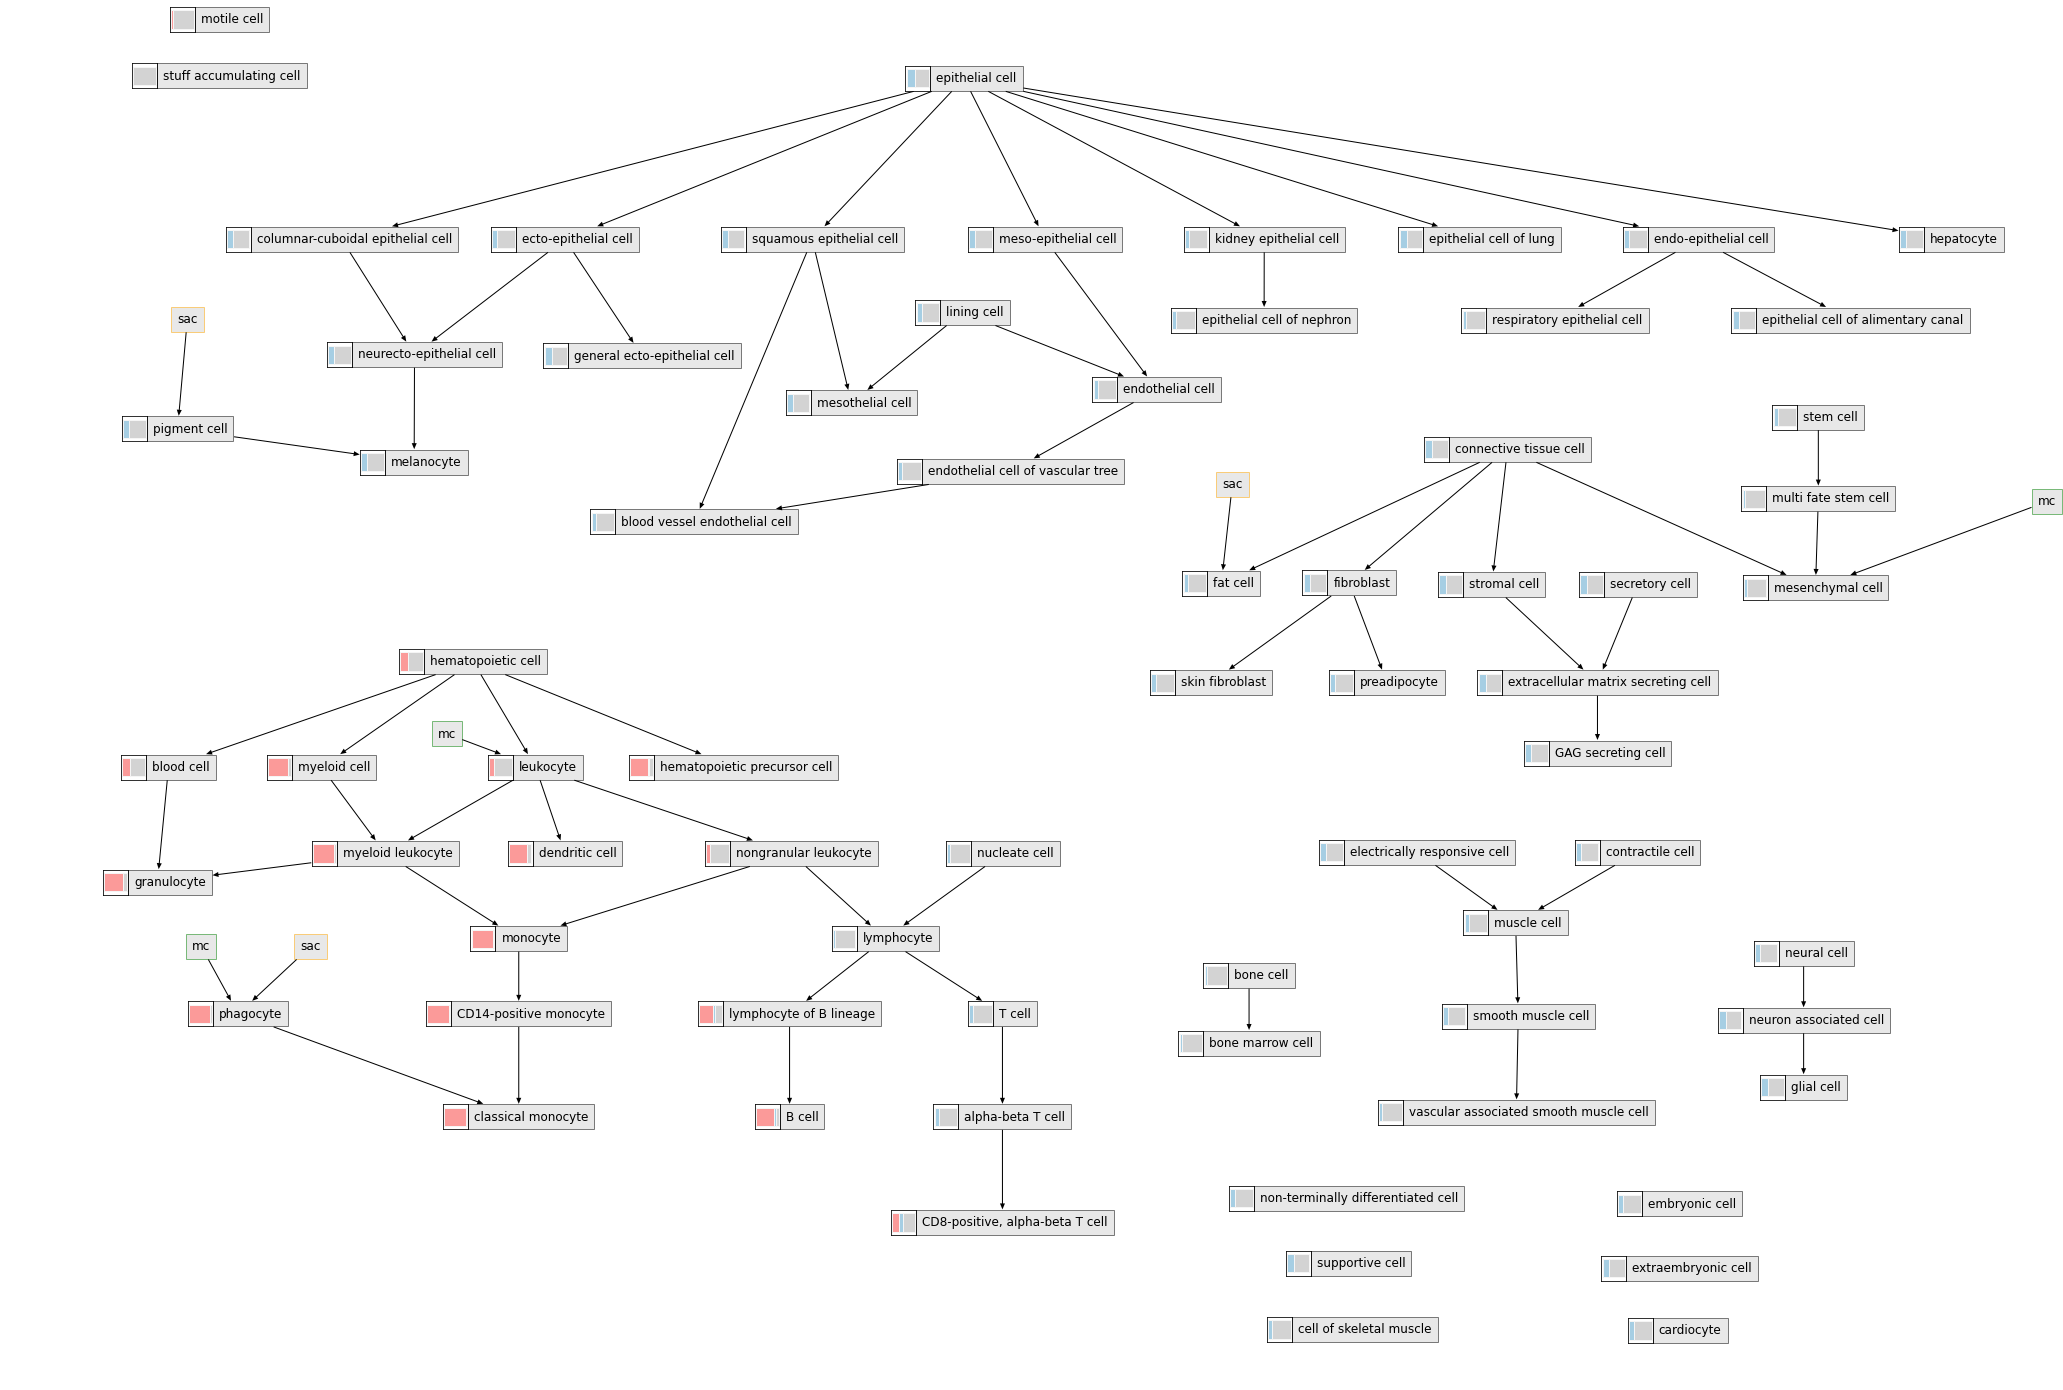

In [6]:
fig, ax = plt.subplots(figsize=(35,25))

ax.set_ylim(-100, 2500)
ax.set_xlim(-250, 2750)

node_to_text = {}
node_to_patch = {}
node_to_patch_center = {}

for node_id, node in nodes.items():
    bbox = dict(facecolor='lightgrey', edgecolor=node["color"], 
                alpha=0.5, pad=PAD)
    t = ax.text(node["x"], node["y"], node["name"], ha="center", 
                va="center", fontsize=12, bbox=bbox)
    
    if node["type"] == "chart_node":
        p = custom_node(node, t, ax, fig)
        node_to_patch[node_id] = p
    
        node_to_patch_center[node_id] = {
            "x": p.get_x() + p.get_width()/2,
            "y": p.get_y() + p.get_height()/2}
    else:
        node_to_patch[node_id] = t
        node_to_patch_center[node_id] = {"x": node["x"], "y": node["y"]}

for edge_id, edge in edges.items():
    v, u = (edge["source"], edge["target"])
    pos_u, pos_v = (node_to_patch_center[u], node_to_patch_center[v])
    arrow_coord = (pos_u["x"], pos_u["y"], pos_v["x"], pos_v["y"])
    ux,uy, vx, vy = arrow_coord
    ax.annotate("", (vx,vy), xytext=(ux,uy), arrowprops=dict(
        facecolor='black', patchA=node_to_patch[u], patchB=node_to_patch[v], shrinkA=.1, shrinkB=20,lw=.01,ec="black",headwidth=5,headlength=6,width=1))
ax.axis("off")
fig.savefig("cl_spi1.pdf", bbox_inches='tight')
fig.savefig("cl_spi1.png", bbox_inches='tight')

In [7]:
def custom_node(node_name, node_pos, ax, fig):
    node_name_att = node_pos[node_name]
    node_name_x = node_name_att["x"]
    node_name_y = node_name_att["y"]

    t = ax.annotate(node_name, (node_name_x, node_name_y), ha="center", va="center", fontsize=12)
    renderer = fig.canvas.get_renderer()
    bbox_text = t.get_window_extent(renderer=renderer)

    x_display, y_display = ax.transData.transform((node_name_x, node_name_y))
    x_ax, y_ax = fig.transFigure.inverted().transform((x_display, y_display))

    w_display, h_display = (bbox_text.width*1.2, bbox_text.height*3)
    w_ax, h_ax = fig.transFigure.inverted().transform((w_display, h_display))

    ax1 = fig.add_axes([x_ax-w_ax/2, y_ax-h_ax/2, w_ax, h_ax])
#     rect = ax1.patch
#     rect.set_facecolor('white')

    ax1.barh([1], [.40], color="#fb9a99", edgecolor="whitesmoke")
    ax1.barh([1], [.40], left=[.40], color="#a6cee3", edgecolor="whitesmoke")
    ax1.barh([1], [.20], left=[.80], color="lightgray", edgecolor="whitesmoke")
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(0.45, 1.55)
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis("off")
    # t = ax.annotate(node_name, (node_name_x, node_name_y), ha="center", va="center")
    t = ax1.text(0.5, 0.5, node_name, ha="center", va="center", transform=ax1.transAxes, fontsize=12)
    return ax1

NameError: name 'G_hema' is not defined

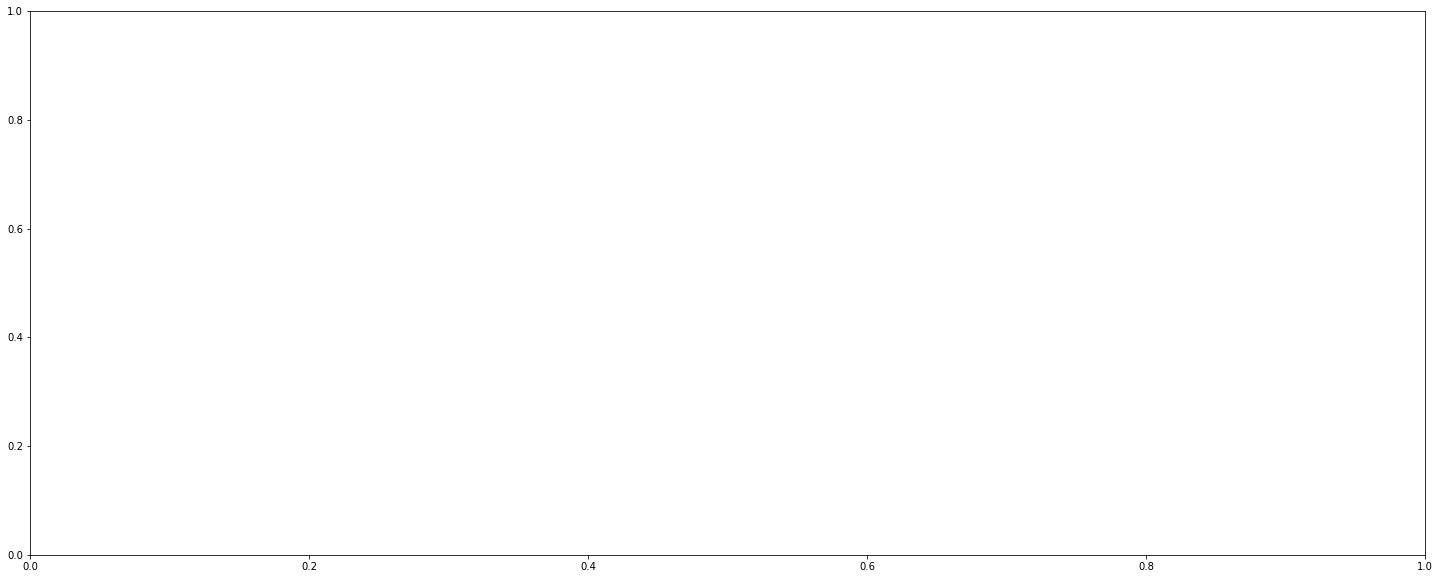

In [8]:
fig, ax = plt.subplots(figsize=(25,10))
# G_hema = G.subgraph(["hematopoietic cell"] + list(nx.algorithms.dag.descendants(G, "hematopoietic cell")))
pos = graphviz_layout(G_hema, prog='dot')
pos = {k: (v["x"], v["y"]) for k, v in node_pos.items() if k }
nx.draw(G_hema, pos, with_labels=True, arrows=True,node_shape="s", ax=ax)
# nx.draw_networkx_edges(G_hema, pos, arrows=True, ax=ax, arrowsize=10)
# nx.draw_networkx_nodes(G_hema, pos, with_labels=True, arrows=True,node_shape="s", ax=ax)

ax.set_ylim(-100, 2500)
ax.set_xlim(-250, 2750)


for node in G_hema.nodes:
    new_ax = custom_node(node, node_pos, ax, fig)
